In [ ]:
#13.3.2 GAN 구현하기

In [1]:
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib
import matplotlib.pylab as plt

from torchvision.utils import make_grid, save_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
batch_size = 512
epochs = 200
sample_size = 64 
nz = 128 
k = 1 

In [3]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

train_dataset = datasets.MNIST(
    root="./data", train=True, transform=transform, download=True)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

100%|██████████| 9912422/9912422 [00:00<00:00, 299813309.42it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 42178166.37it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 171669845.52it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5381505.30it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [4]:
class Generator(nn.Module):  # 
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3), # 30%의 확률 
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [6]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print(generator)
print(discriminator)

Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [7]:
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

criterion = nn.BCELoss()

losses_g = [] 
losses_d = [] 
images = [] 

In [8]:
def save_generator_image(image, path):
    save_image(image, path)

In [9]:
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = torch.ones(b_size, 1).to(device)
    fake_label = torch.zeros(b_size, 1).to(device)
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

In [10]:
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)    
    real_label = torch.ones(b_size, 1).to(device)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

In [11]:
#img 폴더 만들기
!mkdir img

In [24]:
generator.train()
discriminator.train()

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for idx, data in tqdm(enumerate(train_loader), total=int(len(train_dataset)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        for step in range(k):                                
            data_fake = generator(torch.randn(b_size, nz).to(device)).detach()
            data_real = image
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(torch.randn(b_size, nz).to(device))
        loss_g += train_generator(optim_g, data_fake)
    generated_img = generator(torch.randn(b_size, nz).to(device)).cpu().detach()
    generated_img = make_grid(generated_img)
    save_generator_image(generated_img, f"./img/gen_img{epoch}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / idx 
    epoch_loss_d = loss_d / idx 
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

118it [00:06, 19.35it/s]                         


Epoch 0 of 200
Generator loss: 1.29271400, Discriminator loss: 1.09263432


118it [00:06, 17.00it/s]                         


Epoch 1 of 200
Generator loss: 1.23878324, Discriminator loss: 1.08908975


118it [00:07, 15.98it/s]                         


Epoch 2 of 200
Generator loss: 1.27283680, Discriminator loss: 1.08316433


118it [00:08, 14.68it/s]                         


Epoch 3 of 200
Generator loss: 1.19898343, Discriminator loss: 1.11598825


118it [00:07, 16.15it/s]                         


Epoch 4 of 200
Generator loss: 1.24792421, Discriminator loss: 1.09563684


118it [00:07, 16.17it/s]                         


Epoch 5 of 200
Generator loss: 1.24123931, Discriminator loss: 1.09728980


118it [00:06, 17.14it/s]                         


Epoch 6 of 200
Generator loss: 1.24236071, Discriminator loss: 1.09512603


118it [00:07, 15.71it/s]                         


Epoch 7 of 200
Generator loss: 1.27589273, Discriminator loss: 1.09253585


118it [00:07, 16.68it/s]                         


Epoch 8 of 200
Generator loss: 1.23953986, Discriminator loss: 1.10141218


118it [00:06, 17.52it/s]                         


Epoch 9 of 200
Generator loss: 1.23903239, Discriminator loss: 1.10499823


118it [00:07, 16.13it/s]                         


Epoch 10 of 200
Generator loss: 1.28281498, Discriminator loss: 1.07713187


118it [00:08, 14.63it/s]                         


Epoch 11 of 200
Generator loss: 1.23588717, Discriminator loss: 1.10440159


118it [00:07, 15.88it/s]                         


Epoch 12 of 200
Generator loss: 1.17240095, Discriminator loss: 1.12925959


118it [00:07, 16.43it/s]                         


Epoch 13 of 200
Generator loss: 1.21273100, Discriminator loss: 1.11481237


118it [00:07, 16.44it/s]                         


Epoch 14 of 200
Generator loss: 1.28285575, Discriminator loss: 1.09146988


118it [00:07, 15.33it/s]                         


Epoch 15 of 200
Generator loss: 1.23733020, Discriminator loss: 1.11391509


118it [00:07, 15.24it/s]                         


Epoch 16 of 200
Generator loss: 1.25050199, Discriminator loss: 1.09590483


118it [00:06, 16.93it/s]                         


Epoch 17 of 200
Generator loss: 1.27301598, Discriminator loss: 1.09926558


118it [00:07, 16.44it/s]                         


Epoch 18 of 200
Generator loss: 1.25897336, Discriminator loss: 1.09268630


118it [00:06, 16.97it/s]                         


Epoch 19 of 200
Generator loss: 1.21586657, Discriminator loss: 1.11417270


118it [00:07, 16.09it/s]                         


Epoch 20 of 200
Generator loss: 1.16115737, Discriminator loss: 1.12789869


118it [00:08, 14.61it/s]                         


Epoch 21 of 200
Generator loss: 1.23739660, Discriminator loss: 1.09818506


118it [00:09, 12.87it/s]                         


Epoch 22 of 200
Generator loss: 1.21494579, Discriminator loss: 1.11981666


118it [00:08, 13.29it/s]                         


Epoch 23 of 200
Generator loss: 1.22001278, Discriminator loss: 1.10830855


118it [00:07, 15.44it/s]                         


Epoch 24 of 200
Generator loss: 1.24387276, Discriminator loss: 1.11372554


118it [00:07, 16.12it/s]                         


Epoch 25 of 200
Generator loss: 1.22625136, Discriminator loss: 1.11913824


118it [00:07, 16.14it/s]                         


Epoch 26 of 200
Generator loss: 1.22333062, Discriminator loss: 1.10703230


118it [00:08, 14.23it/s]                         


Epoch 27 of 200
Generator loss: 1.24815142, Discriminator loss: 1.09948480


118it [00:07, 16.72it/s]                         


Epoch 28 of 200
Generator loss: 1.21882451, Discriminator loss: 1.11616421


118it [00:07, 15.50it/s]                         


Epoch 29 of 200
Generator loss: 1.22625530, Discriminator loss: 1.11174548


118it [00:07, 15.82it/s]                         


Epoch 30 of 200
Generator loss: 1.17770696, Discriminator loss: 1.11316323


118it [00:07, 14.97it/s]                         


Epoch 31 of 200
Generator loss: 1.20658875, Discriminator loss: 1.12194204


118it [00:06, 16.88it/s]                         


Epoch 32 of 200
Generator loss: 1.23595309, Discriminator loss: 1.10954463


118it [00:06, 17.00it/s]                         


Epoch 33 of 200
Generator loss: 1.19487965, Discriminator loss: 1.13452899


118it [00:07, 15.39it/s]                         


Epoch 34 of 200
Generator loss: 1.19871163, Discriminator loss: 1.13249147


118it [00:08, 14.31it/s]                         


Epoch 35 of 200
Generator loss: 1.16999006, Discriminator loss: 1.14364159


118it [00:07, 16.01it/s]                         


Epoch 36 of 200
Generator loss: 1.20281494, Discriminator loss: 1.11706817


118it [00:08, 14.38it/s]                         


Epoch 37 of 200
Generator loss: 1.19197631, Discriminator loss: 1.13102853


118it [00:07, 16.24it/s]                         


Epoch 38 of 200
Generator loss: 1.22448087, Discriminator loss: 1.09892893


118it [00:07, 15.80it/s]                         


Epoch 39 of 200
Generator loss: 1.21015990, Discriminator loss: 1.11929977


118it [00:06, 17.11it/s]                         


Epoch 40 of 200
Generator loss: 1.21591365, Discriminator loss: 1.11520565


118it [00:07, 15.98it/s]                         


Epoch 41 of 200
Generator loss: 1.21110618, Discriminator loss: 1.12292290


118it [00:07, 16.35it/s]                         


Epoch 42 of 200
Generator loss: 1.19250524, Discriminator loss: 1.11955440


118it [00:07, 15.17it/s]                         


Epoch 43 of 200
Generator loss: 1.20947814, Discriminator loss: 1.11665654


118it [00:07, 16.75it/s]                         


Epoch 44 of 200
Generator loss: 1.24277067, Discriminator loss: 1.11789680


118it [00:07, 15.32it/s]                         


Epoch 45 of 200
Generator loss: 1.17213607, Discriminator loss: 1.13693905


118it [00:07, 16.39it/s]                         


Epoch 46 of 200
Generator loss: 1.19936848, Discriminator loss: 1.12961400


118it [00:07, 16.15it/s]                         


Epoch 47 of 200
Generator loss: 1.20200157, Discriminator loss: 1.12812603


118it [00:06, 17.13it/s]                         


Epoch 48 of 200
Generator loss: 1.19585061, Discriminator loss: 1.12333751


118it [00:07, 16.11it/s]                         


Epoch 49 of 200
Generator loss: 1.16355658, Discriminator loss: 1.14074731


118it [00:09, 12.68it/s]                         


Epoch 50 of 200
Generator loss: 1.17584944, Discriminator loss: 1.14030433


118it [00:08, 14.42it/s]                         


Epoch 51 of 200
Generator loss: 1.11717486, Discriminator loss: 1.15685546


118it [00:07, 16.01it/s]                         


Epoch 52 of 200
Generator loss: 1.14272153, Discriminator loss: 1.14394629


118it [00:07, 14.83it/s]                         


Epoch 53 of 200
Generator loss: 1.14866984, Discriminator loss: 1.15048802


118it [00:07, 16.32it/s]                         


Epoch 54 of 200
Generator loss: 1.15085995, Discriminator loss: 1.15336251


118it [00:07, 16.53it/s]                         


Epoch 55 of 200
Generator loss: 1.15708566, Discriminator loss: 1.13343596


118it [00:06, 17.89it/s]                         


Epoch 56 of 200
Generator loss: 1.16655993, Discriminator loss: 1.14574814


118it [00:07, 16.78it/s]                         


Epoch 57 of 200
Generator loss: 1.17857325, Discriminator loss: 1.13442457


118it [00:07, 15.45it/s]                         


Epoch 58 of 200
Generator loss: 1.17810059, Discriminator loss: 1.14288795


118it [00:07, 16.12it/s]                         


Epoch 59 of 200
Generator loss: 1.12988555, Discriminator loss: 1.16147745


118it [00:07, 16.23it/s]                         


Epoch 60 of 200
Generator loss: 1.13732815, Discriminator loss: 1.14807105


118it [00:07, 15.09it/s]                         


Epoch 61 of 200
Generator loss: 1.16178167, Discriminator loss: 1.14733553


118it [00:06, 18.05it/s]                         


Epoch 62 of 200
Generator loss: 1.15193820, Discriminator loss: 1.14764738


118it [00:06, 17.41it/s]                         


Epoch 63 of 200
Generator loss: 1.15581584, Discriminator loss: 1.15218699


118it [00:07, 15.23it/s]                         


Epoch 64 of 200
Generator loss: 1.15074968, Discriminator loss: 1.14078021


118it [00:07, 16.64it/s]                         


Epoch 65 of 200
Generator loss: 1.14140701, Discriminator loss: 1.15548527


118it [00:06, 17.42it/s]                         


Epoch 66 of 200
Generator loss: 1.15912354, Discriminator loss: 1.12889993


118it [00:07, 15.83it/s]                         


Epoch 67 of 200
Generator loss: 1.16714537, Discriminator loss: 1.13753426


118it [00:06, 16.92it/s]                         


Epoch 68 of 200
Generator loss: 1.16926920, Discriminator loss: 1.15223849


118it [00:06, 16.87it/s]                         


Epoch 69 of 200
Generator loss: 1.14305067, Discriminator loss: 1.15649533


118it [00:06, 17.15it/s]                         


Epoch 70 of 200
Generator loss: 1.10367906, Discriminator loss: 1.16402400


118it [00:08, 14.61it/s]                         


Epoch 71 of 200
Generator loss: 1.13426471, Discriminator loss: 1.15351474


118it [00:07, 15.06it/s]                         


Epoch 72 of 200
Generator loss: 1.11496603, Discriminator loss: 1.16243422


118it [00:08, 14.73it/s]                         


Epoch 73 of 200
Generator loss: 1.12331843, Discriminator loss: 1.16501689


118it [00:07, 15.18it/s]                         


Epoch 74 of 200
Generator loss: 1.16341364, Discriminator loss: 1.14973998


118it [00:07, 15.04it/s]                         


Epoch 75 of 200
Generator loss: 1.15435278, Discriminator loss: 1.16000426


118it [00:08, 14.58it/s]                         


Epoch 76 of 200
Generator loss: 1.13394797, Discriminator loss: 1.14954579


118it [00:07, 14.82it/s]                         


Epoch 77 of 200
Generator loss: 1.12157619, Discriminator loss: 1.17193341


118it [00:08, 14.05it/s]                         


Epoch 78 of 200
Generator loss: 1.09193552, Discriminator loss: 1.18174398


118it [00:07, 16.05it/s]                         


Epoch 79 of 200
Generator loss: 1.11963415, Discriminator loss: 1.16560888


118it [00:07, 14.95it/s]                         


Epoch 80 of 200
Generator loss: 1.14892793, Discriminator loss: 1.15557754


118it [00:09, 11.94it/s]                         


Epoch 81 of 200
Generator loss: 1.10777318, Discriminator loss: 1.18290555


118it [00:06, 17.21it/s]                         


Epoch 82 of 200
Generator loss: 1.12124288, Discriminator loss: 1.15621626


118it [00:08, 13.78it/s]                         


Epoch 83 of 200
Generator loss: 1.11158645, Discriminator loss: 1.17279506


118it [00:06, 17.67it/s]                         


Epoch 84 of 200
Generator loss: 1.08467889, Discriminator loss: 1.18435240


118it [00:07, 15.42it/s]                         


Epoch 85 of 200
Generator loss: 1.10568821, Discriminator loss: 1.16286302


118it [00:07, 16.47it/s]                         


Epoch 86 of 200
Generator loss: 1.14828289, Discriminator loss: 1.17274570


118it [00:08, 14.59it/s]                         


Epoch 87 of 200
Generator loss: 1.11550200, Discriminator loss: 1.16019011


118it [00:09, 13.11it/s]                         


Epoch 88 of 200
Generator loss: 1.13005388, Discriminator loss: 1.16196918


118it [00:07, 15.49it/s]                         


Epoch 89 of 200
Generator loss: 1.11851621, Discriminator loss: 1.15661657


118it [00:08, 14.00it/s]                         


Epoch 90 of 200
Generator loss: 1.11586297, Discriminator loss: 1.15906692


118it [00:07, 16.05it/s]                         


Epoch 91 of 200
Generator loss: 1.10700893, Discriminator loss: 1.17489326


118it [00:07, 16.04it/s]                         


Epoch 92 of 200
Generator loss: 1.11837244, Discriminator loss: 1.15474105


118it [00:07, 16.36it/s]                         


Epoch 93 of 200
Generator loss: 1.10674930, Discriminator loss: 1.18197632


118it [00:06, 16.87it/s]                         


Epoch 94 of 200
Generator loss: 1.09523153, Discriminator loss: 1.16787338


118it [00:06, 17.10it/s]                         


Epoch 95 of 200
Generator loss: 1.09591627, Discriminator loss: 1.18189478


118it [00:06, 16.90it/s]                         


Epoch 96 of 200
Generator loss: 1.12867725, Discriminator loss: 1.16360831


118it [00:06, 17.69it/s]                         


Epoch 97 of 200
Generator loss: 1.09354913, Discriminator loss: 1.18791091


118it [00:06, 17.74it/s]                         


Epoch 98 of 200
Generator loss: 1.11802661, Discriminator loss: 1.16080153


118it [00:06, 17.40it/s]                         


Epoch 99 of 200
Generator loss: 1.11439300, Discriminator loss: 1.17222095


118it [00:06, 17.60it/s]                         


Epoch 100 of 200
Generator loss: 1.09335876, Discriminator loss: 1.17265582


118it [00:07, 15.67it/s]                         


Epoch 101 of 200
Generator loss: 1.10544121, Discriminator loss: 1.17103469


118it [00:07, 16.40it/s]                         


Epoch 102 of 200
Generator loss: 1.09769666, Discriminator loss: 1.17125463


118it [00:06, 16.88it/s]                         


Epoch 103 of 200
Generator loss: 1.12169421, Discriminator loss: 1.18146324


118it [00:07, 15.55it/s]                         


Epoch 104 of 200
Generator loss: 1.08097494, Discriminator loss: 1.17579150


118it [00:07, 14.89it/s]                         


Epoch 105 of 200
Generator loss: 1.11513793, Discriminator loss: 1.17163277


118it [00:07, 15.77it/s]                         


Epoch 106 of 200
Generator loss: 1.07343161, Discriminator loss: 1.18114567


118it [00:07, 16.49it/s]                         


Epoch 107 of 200
Generator loss: 1.13970351, Discriminator loss: 1.16759348


118it [00:06, 17.50it/s]                         


Epoch 108 of 200
Generator loss: 1.05116224, Discriminator loss: 1.19629002


118it [00:06, 17.92it/s]                         


Epoch 109 of 200
Generator loss: 1.10472453, Discriminator loss: 1.19114113


118it [00:06, 17.82it/s]                         


Epoch 110 of 200
Generator loss: 1.06805348, Discriminator loss: 1.20398378


118it [00:06, 17.89it/s]                         


Epoch 111 of 200
Generator loss: 1.13720620, Discriminator loss: 1.16699076


118it [00:06, 17.53it/s]                         


Epoch 112 of 200
Generator loss: 1.13709509, Discriminator loss: 1.18467844


118it [00:07, 16.33it/s]                         


Epoch 113 of 200
Generator loss: 1.09549153, Discriminator loss: 1.20396030


118it [00:07, 16.07it/s]                         


Epoch 114 of 200
Generator loss: 1.07572865, Discriminator loss: 1.17739928


118it [00:06, 17.02it/s]                         


Epoch 115 of 200
Generator loss: 1.10725939, Discriminator loss: 1.17647159


118it [00:07, 16.08it/s]                         


Epoch 116 of 200
Generator loss: 1.08834815, Discriminator loss: 1.17622733


118it [00:07, 16.44it/s]                         


Epoch 117 of 200
Generator loss: 1.08740294, Discriminator loss: 1.17666686


118it [00:07, 16.22it/s]                         


Epoch 118 of 200
Generator loss: 1.10631073, Discriminator loss: 1.18677151


118it [00:07, 16.43it/s]                         


Epoch 119 of 200
Generator loss: 1.10079527, Discriminator loss: 1.16679657


118it [00:07, 16.02it/s]                         


Epoch 120 of 200
Generator loss: 1.09796250, Discriminator loss: 1.18517411


118it [00:06, 17.00it/s]                         


Epoch 121 of 200
Generator loss: 1.07670689, Discriminator loss: 1.18394566


118it [00:09, 11.96it/s]                         


Epoch 122 of 200
Generator loss: 1.09361267, Discriminator loss: 1.17922437


118it [00:07, 16.43it/s]                         


Epoch 123 of 200
Generator loss: 1.04497421, Discriminator loss: 1.20870674


118it [00:07, 15.90it/s]                         


Epoch 124 of 200
Generator loss: 1.07242572, Discriminator loss: 1.20460320


118it [00:07, 15.23it/s]                         


Epoch 125 of 200
Generator loss: 1.05999804, Discriminator loss: 1.21236610


118it [00:08, 14.37it/s]                         


Epoch 126 of 200
Generator loss: 1.02817571, Discriminator loss: 1.20435560


118it [00:07, 16.25it/s]                         


Epoch 127 of 200
Generator loss: 1.04880309, Discriminator loss: 1.19261920


118it [00:07, 16.16it/s]                         


Epoch 128 of 200
Generator loss: 1.08484173, Discriminator loss: 1.18815494


118it [00:07, 16.26it/s]                         


Epoch 129 of 200
Generator loss: 1.06768620, Discriminator loss: 1.19874704


118it [00:06, 17.48it/s]                         


Epoch 130 of 200
Generator loss: 1.04659653, Discriminator loss: 1.20085895


118it [00:07, 15.98it/s]                         


Epoch 131 of 200
Generator loss: 1.07011938, Discriminator loss: 1.19410419


118it [00:07, 15.06it/s]                         


Epoch 132 of 200
Generator loss: 1.09710550, Discriminator loss: 1.16818130


118it [00:07, 15.62it/s]                         


Epoch 133 of 200
Generator loss: 1.06868589, Discriminator loss: 1.19095016


118it [00:07, 15.20it/s]                         


Epoch 134 of 200
Generator loss: 1.05748105, Discriminator loss: 1.19178867


118it [00:07, 15.83it/s]                         


Epoch 135 of 200
Generator loss: 1.09484637, Discriminator loss: 1.19466162


118it [00:06, 17.36it/s]                         


Epoch 136 of 200
Generator loss: 1.11029601, Discriminator loss: 1.18240380


118it [00:06, 16.90it/s]                         


Epoch 137 of 200
Generator loss: 1.10101867, Discriminator loss: 1.19126999


118it [00:07, 16.27it/s]                         


Epoch 138 of 200
Generator loss: 1.06339741, Discriminator loss: 1.18476558


118it [00:07, 16.76it/s]                         


Epoch 139 of 200
Generator loss: 1.08066952, Discriminator loss: 1.19649696


118it [00:07, 16.78it/s]                         


Epoch 140 of 200
Generator loss: 1.04855216, Discriminator loss: 1.20620441


118it [00:07, 15.89it/s]                         


Epoch 141 of 200
Generator loss: 1.04870009, Discriminator loss: 1.20474613


118it [00:08, 14.71it/s]                         


Epoch 142 of 200
Generator loss: 1.04981327, Discriminator loss: 1.20681286


118it [00:07, 15.16it/s]                         


Epoch 143 of 200
Generator loss: 1.04622519, Discriminator loss: 1.23028481


118it [00:07, 15.84it/s]                         


Epoch 144 of 200
Generator loss: 1.01792657, Discriminator loss: 1.21650708


118it [00:07, 15.38it/s]                         


Epoch 145 of 200
Generator loss: 1.03162062, Discriminator loss: 1.20755768


118it [00:07, 15.84it/s]                         


Epoch 146 of 200
Generator loss: 1.04618585, Discriminator loss: 1.21027195


118it [00:07, 16.03it/s]                         


Epoch 147 of 200
Generator loss: 1.07838142, Discriminator loss: 1.20917261


118it [00:07, 15.20it/s]                         


Epoch 148 of 200
Generator loss: 1.08216119, Discriminator loss: 1.18494499


118it [00:07, 15.52it/s]                         


Epoch 149 of 200
Generator loss: 1.06198859, Discriminator loss: 1.18641472


118it [00:07, 15.57it/s]                         


Epoch 150 of 200
Generator loss: 1.04827833, Discriminator loss: 1.19445491


118it [00:07, 15.38it/s]                         


Epoch 151 of 200
Generator loss: 1.05974030, Discriminator loss: 1.20554328


118it [00:07, 16.54it/s]                         


Epoch 152 of 200
Generator loss: 1.06051910, Discriminator loss: 1.19586766


118it [00:07, 15.36it/s]                         


Epoch 153 of 200
Generator loss: 1.02917826, Discriminator loss: 1.20593417


118it [00:07, 15.55it/s]                         


Epoch 154 of 200
Generator loss: 1.07211125, Discriminator loss: 1.19824314


118it [00:07, 15.93it/s]                         


Epoch 155 of 200
Generator loss: 1.06787872, Discriminator loss: 1.20133293


118it [00:07, 15.31it/s]                         


Epoch 156 of 200
Generator loss: 1.05098045, Discriminator loss: 1.21732640


118it [00:07, 16.76it/s]                         


Epoch 157 of 200
Generator loss: 1.09261429, Discriminator loss: 1.19607568


118it [00:07, 15.87it/s]                         


Epoch 158 of 200
Generator loss: 1.07819629, Discriminator loss: 1.19612014


118it [00:07, 15.08it/s]                         


Epoch 159 of 200
Generator loss: 1.04434574, Discriminator loss: 1.20774949


118it [00:07, 15.63it/s]                         


Epoch 160 of 200
Generator loss: 1.03929949, Discriminator loss: 1.20986855


118it [00:07, 15.97it/s]                         


Epoch 161 of 200
Generator loss: 1.03934789, Discriminator loss: 1.21727324


118it [00:07, 15.49it/s]                         


Epoch 162 of 200
Generator loss: 1.05557239, Discriminator loss: 1.20272517


118it [00:07, 16.56it/s]                         


Epoch 163 of 200
Generator loss: 1.05816662, Discriminator loss: 1.20154202


118it [00:08, 13.44it/s]                         


Epoch 164 of 200
Generator loss: 1.03629708, Discriminator loss: 1.20493793


118it [00:07, 15.40it/s]                         


Epoch 165 of 200
Generator loss: 1.04408169, Discriminator loss: 1.19562149


118it [00:07, 16.14it/s]                         


Epoch 166 of 200
Generator loss: 1.05599332, Discriminator loss: 1.20328307


118it [00:07, 15.32it/s]                         


Epoch 167 of 200
Generator loss: 1.04575920, Discriminator loss: 1.23367739


118it [00:07, 15.87it/s]                         


Epoch 168 of 200
Generator loss: 1.07446504, Discriminator loss: 1.22433579


118it [00:07, 16.18it/s]                         


Epoch 169 of 200
Generator loss: 1.01142788, Discriminator loss: 1.21981490


118it [00:07, 16.32it/s]                         


Epoch 170 of 200
Generator loss: 1.05688322, Discriminator loss: 1.20050919


118it [00:07, 15.77it/s]                         


Epoch 171 of 200
Generator loss: 1.01318705, Discriminator loss: 1.22248614


118it [00:07, 15.63it/s]                         


Epoch 172 of 200
Generator loss: 1.04263520, Discriminator loss: 1.21866381


118it [00:07, 15.17it/s]                         


Epoch 173 of 200
Generator loss: 1.01777399, Discriminator loss: 1.23237109


118it [00:07, 15.02it/s]                         


Epoch 174 of 200
Generator loss: 1.01777577, Discriminator loss: 1.21865654


118it [00:08, 13.64it/s]                         


Epoch 175 of 200
Generator loss: 1.00957632, Discriminator loss: 1.24597251


118it [00:07, 15.75it/s]                         


Epoch 176 of 200
Generator loss: 1.00630748, Discriminator loss: 1.23154187


118it [00:07, 16.25it/s]                         


Epoch 177 of 200
Generator loss: 1.01304674, Discriminator loss: 1.22113264


118it [00:07, 16.00it/s]                         


Epoch 178 of 200
Generator loss: 1.01661038, Discriminator loss: 1.22945035


118it [00:07, 15.58it/s]                         


Epoch 179 of 200
Generator loss: 1.05335891, Discriminator loss: 1.20220792


118it [00:07, 15.75it/s]                         


Epoch 180 of 200
Generator loss: 1.03406000, Discriminator loss: 1.21085584


118it [00:07, 15.02it/s]                         


Epoch 181 of 200
Generator loss: 1.02068865, Discriminator loss: 1.22006691


118it [00:07, 15.79it/s]                         


Epoch 182 of 200
Generator loss: 1.06720114, Discriminator loss: 1.20587611


118it [00:08, 14.46it/s]                         


Epoch 183 of 200
Generator loss: 1.03385568, Discriminator loss: 1.20969105


118it [00:07, 15.69it/s]                         


Epoch 184 of 200
Generator loss: 1.03405738, Discriminator loss: 1.21812630


118it [00:08, 13.60it/s]                         


Epoch 185 of 200
Generator loss: 1.03865051, Discriminator loss: 1.21978033


118it [00:08, 13.62it/s]                         


Epoch 186 of 200
Generator loss: 1.01411188, Discriminator loss: 1.22046673


118it [00:08, 14.12it/s]                         


Epoch 187 of 200
Generator loss: 1.02759790, Discriminator loss: 1.20913506


118it [00:08, 13.73it/s]                         


Epoch 188 of 200
Generator loss: 1.01432729, Discriminator loss: 1.21893501


118it [00:07, 14.92it/s]                         


Epoch 189 of 200
Generator loss: 1.02844453, Discriminator loss: 1.21258664


118it [00:08, 13.53it/s]                         


Epoch 190 of 200
Generator loss: 1.05590355, Discriminator loss: 1.20030296


118it [00:08, 14.20it/s]                         


Epoch 191 of 200
Generator loss: 0.99564999, Discriminator loss: 1.23275852


118it [00:08, 14.72it/s]                         


Epoch 192 of 200
Generator loss: 1.02047431, Discriminator loss: 1.22091627


118it [00:07, 15.54it/s]                         


Epoch 193 of 200
Generator loss: 1.03663754, Discriminator loss: 1.21320319


118it [00:07, 15.29it/s]                         


Epoch 194 of 200
Generator loss: 1.02179742, Discriminator loss: 1.21574032


118it [00:08, 13.45it/s]                         


Epoch 195 of 200
Generator loss: 1.02793908, Discriminator loss: 1.21670187


118it [00:08, 14.16it/s]                         


Epoch 196 of 200
Generator loss: 1.03052580, Discriminator loss: 1.21061206


118it [00:07, 15.11it/s]                         


Epoch 197 of 200
Generator loss: 1.00632524, Discriminator loss: 1.23372519


118it [00:07, 15.58it/s]                         


Epoch 198 of 200
Generator loss: 0.98946130, Discriminator loss: 1.22894466


118it [00:07, 15.62it/s]                         

Epoch 199 of 200
Generator loss: 1.01044047, Discriminator loss: 1.23260331


In [26]:
plt.figure()
losses_g = [fl.item() for fl in losses_g ]
plt.plot(losses_g, label='Generator loss')
losses_d = [f2.item() for f2 in losses_d ]
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()


AttributeError: 'float' object has no attribute 'item'

<Figure size 640x480 with 0 Axes>

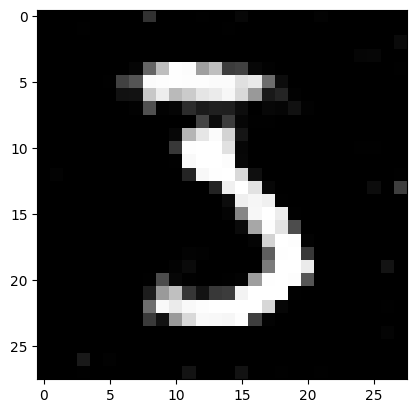

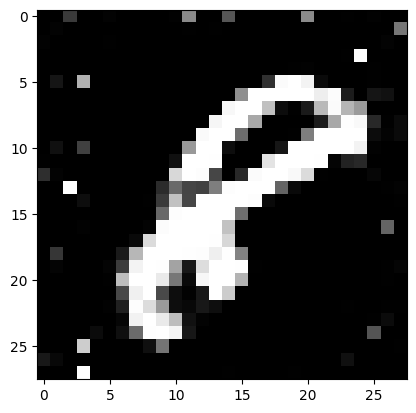

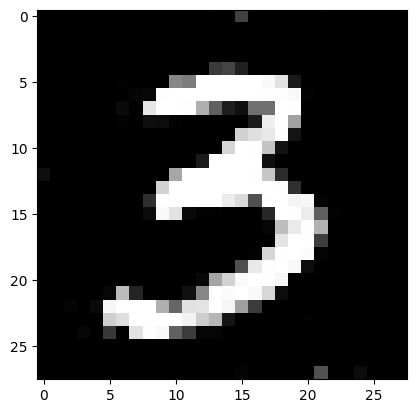

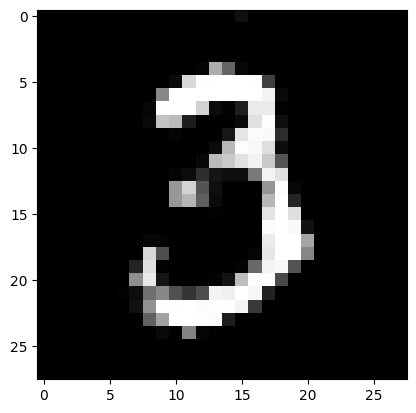

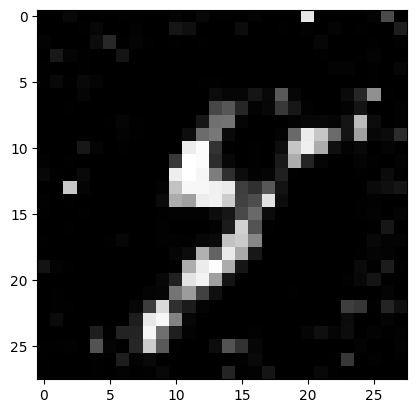

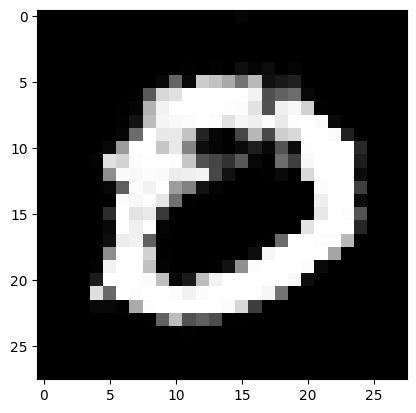

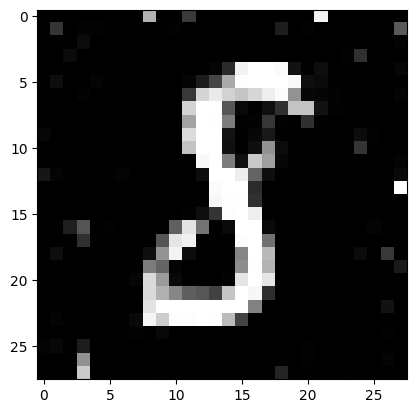

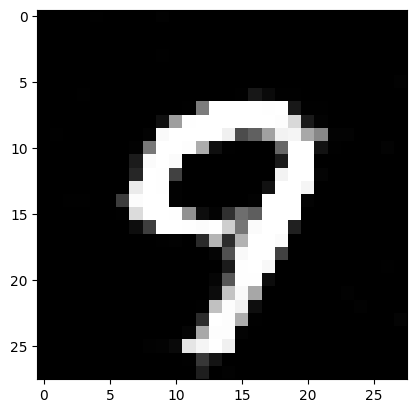

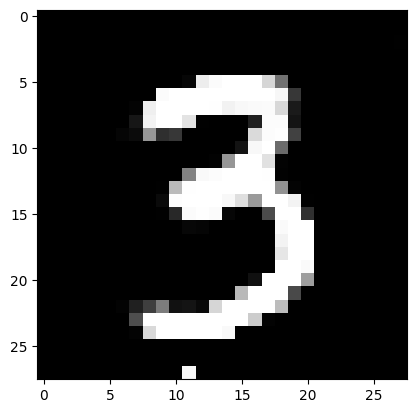

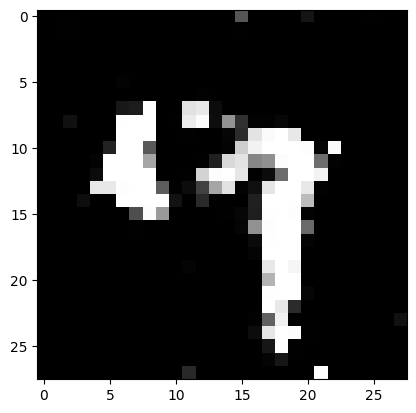

In [27]:
import numpy as np  #추가
fake_images = generator(torch.randn(b_size, nz).to(device))
for i in range(10):
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i],(28, 28))
    plt.imshow(fake_images_img, cmap = 'gray')    
    plt.show()